# Computer Assignment 6 (Neural Networks)

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

from abc import ABC, abstractmethod
from typing import Union, Iterable, Callable
from collections import namedtuple

In [109]:
DATA_DIR = 'data/'

TRAIN_IMAGES = DATA_DIR + 'TrainImgs.csv'
TRAIN_LABELS = DATA_DIR + 'TrainLabels.csv'
TEST_IMAGES  = DATA_DIR + 'TestImgs.csv'
TEST_LABELS  = DATA_DIR + 'TestLabels.csv'

CLASS_COUNT = 28
REMOVABLE_CLASSES = list(range(16, 28))

In [110]:
Image = namedtuple('Image', ['pixels', 'label'])

## Part 1: Data Analysis and Preprocessing

In [111]:
class DataLoader:

    def __init__(self, data: pd.DataFrame, labels: pd.DataFrame, n_classes: int, batch_size: Union[int, None] = None, shuffle: bool = False):
        assert len(data) == len(labels), 'Data and labels must have the same length'
        self._data: pd.DataFrame = data
        self._n_classes: int = n_classes
        self._batch_size: Union[int, None] = batch_size
        self._shuffle: bool = shuffle
        self._labels: pd.DataFrame = self._one_hot_encode(labels, n_classes)

    def _one_hot_encode(self, labels: pd.DataFrame, n_classes: int) -> pd.DataFrame:
        shape = (len(labels), n_classes)
        one_hot = np.zeros(shape)
        one_hot[np.arange(len(labels)), labels.values[:, 0] - 1] = 1
        return pd.DataFrame(one_hot)

    def _shuffle_data(self) -> None:
        data = pd.concat([self._data, self._labels], axis=1)
        data = data.sample(frac=1).reset_index(drop=True)
        self._data = data.iloc[:, :-self._n_classes]
        self._labels = data.iloc[:, -self._n_classes:]

    def __iter__(self) -> Iterable:
        if self._shuffle:
            self._shuffle_data()
            
        if self._batch_size == None:
            yield (np.matrix(self._data), np.matrix(self._labels))
            return
            
        for idx in range(0, len(self._data), self._batch_size):
            yield (np.matrix(self._data[idx:idx+self._batch_size]), 
                   np.matrix(self._labels[idx:idx+self._batch_size]))
            
    def drop_classes(self, classes: list[int]) -> None:
        assert all([c in range(self._n_classes) for c in classes]), 'Classes must be in range [0, n_classes)'
        self._labels = self._labels.drop(columns=classes)
        self._labels = self._labels.loc[(self._labels != 0).any(axis=1)]
        self._data = self._data.loc[self._labels.index]
        self._data = self._data.reset_index(drop=True)
        self._labels = self._labels.reset_index(drop=True)
        self._n_classes = self._labels.shape[1]

    def scale(self, scale: Callable[[pd.Series], pd.Series]) -> None:
        self._data = self._data.apply(scale, axis=1)

    def get_class_images(self, class_idx: int) -> pd.DataFrame:
        assert class_idx in range(self._n_classes), 'Class index must be in range [0, n_classes)'
        return self._data[self._labels[class_idx] == 1]
    
    def get_labels(self) -> pd.DataFrame:
        return pd.DataFrame(np.argmax(self._labels.values, axis=1) + 1)

In [112]:
train_images = pd.read_csv(TRAIN_IMAGES, header=None)
train_labels = pd.read_csv(TRAIN_LABELS, header=None)
train_data = DataLoader(train_images, train_labels, CLASS_COUNT, shuffle=True)

test_images = pd.read_csv(TEST_IMAGES, header=None)
test_labels = pd.read_csv(TEST_LABELS, header=None)
test_data = DataLoader(test_images, test_labels, CLASS_COUNT, shuffle=True)

### 1.1 Plot a Sample of Each Class

In [113]:
def plot_images(images: list[Image], n_cols: int = 5) -> None:
    n_rows = math.ceil(len(images) / n_cols)
    _, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    for i, img in enumerate(images):
        ax = axs[i // n_cols, i % n_cols] # type: ignore
        ax.imshow(img.pixels, cmap='gray')
        ax.set_title(img.label)
        ax.axis('off')
    plt.show()

There are 28 letters in the arabic alphabet. Each letter has a corresponding number from 1 to 28. The following code plots a random sample of each class.

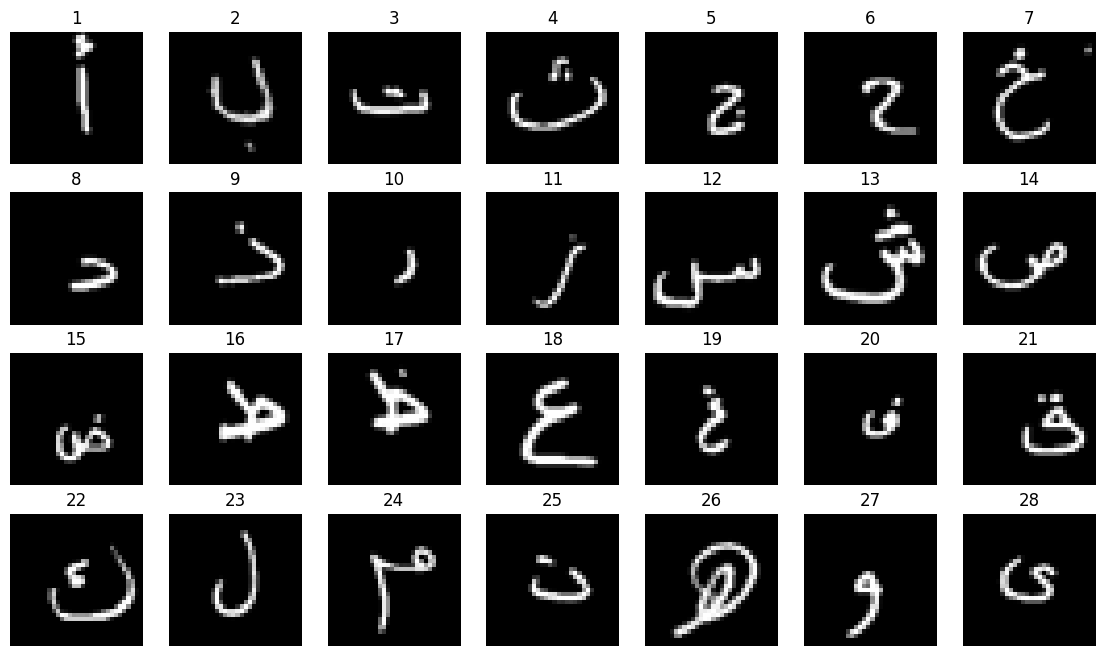

In [114]:
imgs = []
for label in range(CLASS_COUNT):
    img = train_data.get_class_images(label).sample(n=1).values[0].reshape(32, 32)
    img = np.transpose(img)
    imgs.append(Image(img, label + 1))
plot_images(imgs, 7)

### 1.2 Pixels Range

All the pixels in the dataset are in the range [0, 255]. The following code finds the minimum and maximum values of the pixels.

In [115]:
minimum = train_images.min().min()
maximum = train_images.max().max()
print(f'Minimum: {minimum}, Maximum: {maximum}')

Minimum: 0, Maximum: 255


### 1.3 Number of Classes and Samples

In [116]:
class_count = train_labels[0].nunique()
samples_count = train_labels[0].count()
print(f'Number of classes: {class_count}, Number of samples: {samples_count}')

Number of classes: 28, Number of samples: 13440


### 1.4 Using the First 16 Classes

I will use the first 16 classes and the rest of them will be ignored.

In [117]:
train_data.drop_classes(REMOVABLE_CLASSES)
test_data.drop_classes(REMOVABLE_CLASSES)

### 1.5 Number of Samples per Class

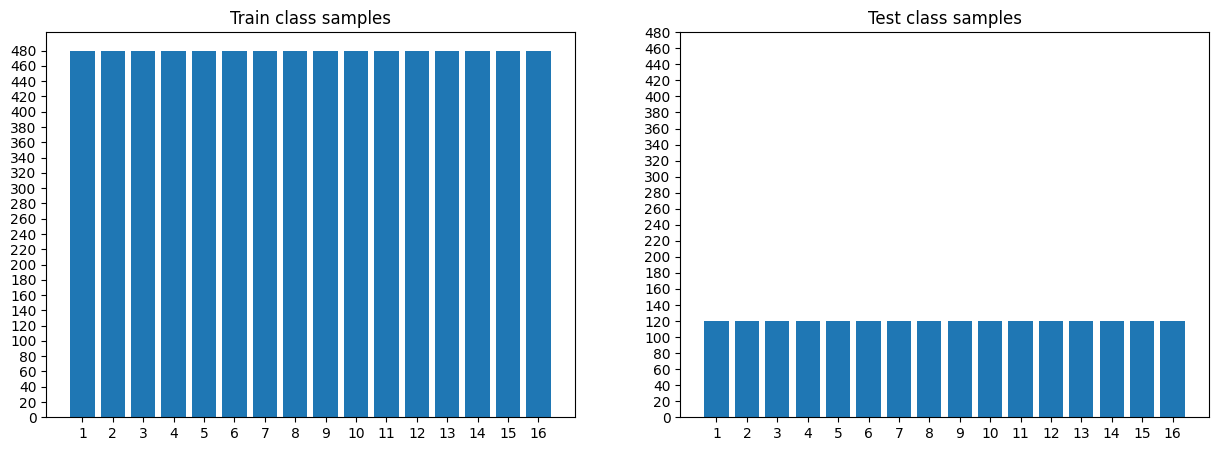

In [118]:
train_labels = train_data.get_labels()
test_labels = test_data.get_labels()

train_class_samples = train_labels[0].value_counts().sort_index()
test_class_samples = test_labels[0].value_counts().sort_index()

_, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].bar(train_class_samples.index, train_class_samples.values) # type: ignore
axs[0].set_title('Train class samples')
axs[0].set_xticks(range(1, 17))
axs[0].set_yticks(range(0, 500, 20))
axs[1].bar(test_class_samples.index, test_class_samples.values) # type: ignore
axs[1].set_title('Test class samples')
axs[1].set_xticks(range(1, 17))
axs[1].set_yticks(range(0, 500, 20))
plt.show()

As it can be seen from the previous plots, the number of samples per class are equal and the dataset is balanced. The training set has 16 classes and each class has 480 samples. The test set has 16 classes and each class has 120 samples.

### 1.6 Scaling the Data

In [119]:
train_data.scale(lambda x: (x - minimum) / (maximum - minimum)) # x /= 255
test_data.scale(lambda x: (x - minimum) / (maximum - minimum)) # x /= 255

The weights will be updated based on the difference between the predicted value and the actual value. If the values of the pixels are in the range [0, 255], the difference between the predicted value and the actual value will be in the range [0, 255]. This will cause the weights to be updated by a large amount, which will make the neural network **take a long time to converge**. To avoid this problem, we will scale (normalize) the data to be in the range [0, 1].

### 1.7 One-Hot Encoding

Labels are one-hot encoded inside the `DataLoader` class. If we don't use one-hot encoding, misclassification will be penalized more than it should be. For example, if the actual label is 1 and the predicted label is 2, the loss will be 1. If the actual label is 1 and the predicted label is 3, the loss will be 2. However, the difference between 1 and 2 is the same as the difference between 1 and 3. Therefore, we should use one-hot encoding to avoid this problem.